## 🌍 Multi-Market Forecast Simulation for Drug X

This notebook runs simulation-based forecasts for Drug X adoption and persistence across multiple countries. Each country's unique launch timeline and eligible population size are considered, creating an aligned, time-extended view of treatment uptake.

#### 🔧 Setup and Assumptions

I start by importing necessary packages, custom functions from `utils.py`, and defining:
- Global parameters common to all markets (e.g., duration of forecast, treatment persistence).
- Market-specific assumptions such as:
  - Annual eligible population
  - Launch date
  - Prescriber uptake trajectory
  - Probability to prescribe Drug X

I also determine how many months to simulate for each country, so that all forecasts align on a common endpoint.

In [1]:
import numpy as np
import pandas as pd

from utils import (
    simulate_monthly_eligibles,
    simulate_pts_seen_by_users,
    simulate_new_pts_treated,
    simulate_treatment_persistence,
    simulate_forecast
)

np.random.seed(123)  # Set a fixed seed for reproducibility

In [2]:
# Define the number of simulations
num_simulations = 10

# assumptions common to all markets
months_to_forecast = 60 # months to forecast (5 years)
median_duration = 10 # persistence on treatment
max_duration = 12 # patients treated until progression

# assumptions varying per market
assumptions = {
    'Country':['China','Germany','France','UK','Italy','Spain','US','Japan'],
    'Annual_Eligible_Pts':[50000, 5500, 4300, 4400, 3900, 3100, 22000, 8300], # yearly eligible patients
    'Launch_Date':['2022-01-01', '2019-12-01', '2024-06-01', '2019-10-01',
                   '2024-12-01', '2022-04-01','2017-07-01','2025-01-01'],
    'initial_user_share':[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
    'max_user_share':[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
    'months_to_peak': [36, 36, 36, 36, 36, 36, 36, 36], # months to reach max % of users
    'Probability_to_prescribe': [0.25, 0.25, 0.25, 0.25,
                                 0.25, 0.25, 0.25, 0.25] # % of eligible patients that users prescribe
}

In [3]:
# create the list of months to forecast per each country based on the respective launch date
last_launch_date = max(assumptions['Launch_Date']) 
n_months_to_forecast = []
for launch in assumptions['Launch_Date']:
    n_months_to_forecast.append(len(pd.date_range(launch,last_launch_date,freq='M')) + months_to_forecast)
    
# adding the months to forecast per country to the dictionary with market assumptions
assumptions['months_to_forecast'] = n_months_to_forecast

assumptions_df = pd.DataFrame(assumptions)

## 🚀 Running Simulations for Each Market

For each country, I simulate:
1. Monthly new eligible patients
2. Uptake by prescribers
3. Probability of treatment
4. Persistence over time

The output is a forecast of patients actively on treatment each month.

In [4]:
# nr of Countries
country_nr = len(assumptions_df['Country'])
results = {} #initialize a dictionary to store each simulation per country

for k in range(country_nr):
    df = simulate_monthly_eligibles(
        annual_eligibles=assumptions_df['Annual_Eligible_Pts'][k],
        n_months=assumptions_df['months_to_forecast'][k],
        start_date=assumptions_df['Launch_Date'][k]
    ) # to be passed to eligible_df argument in the next function
    df = simulate_pts_seen_by_users(
        eligible_df=df,
        max_user_share=assumptions_df['max_user_share'][k],
        initial_user_share=assumptions_df['initial_user_share'][k],
        months_to_peak=assumptions_df['months_to_peak'][k]
    ) # to be passed to user_seen_df argument in the next function
    df = simulate_new_pts_treated(
        user_seen_df=df,
        mean_treatment_prob=assumptions_df['Probability_to_prescribe'][k]
    ) # to be passed to df argument in the next function
    df = simulate_forecast(
        df=df,
        median_duration_months=median_duration,
        max_duration_months=max_duration
    )
    results[assumptions_df['Country'][k]]= df

print(len(results))

8


## 📊 Forecast Results Across Countries

I combine the results into a single DataFrame and plot the monthly number of patients on treatment for each market.

In [5]:
# Extract only the column of interest for the list of simulations DataFrames to be conactenated
multi_country_forecasts = [
    results[country].filter(items=['Pts_on_treatment']) for country in assumptions_df['Country']
]
multi_country_forecasts = pd.concat(multi_country_forecasts, axis=1)
multi_country_forecasts.columns = [country for country in assumptions_df['Country']]
# multi_country_forecasts.index = results[0].index  # optional, ensures consistent datetime index

multi_country_forecasts.head(3)

,China,Germany,France,UK,Italy,Spain,US,Japan
2017-07-31,NaN,NaN,NaN,NaN,NaN,NaN,67,NaN
2017-08-31,NaN,NaN,NaN,NaN,NaN,NaN,131,NaN
2017-09-30,NaN,NaN,NaN,NaN,NaN,NaN,186,NaN


<Axes: title={'center': '5 Year Monthly Forecast of Patients on Drug X per Country'}, xlabel='Time', ylabel='Nr of patients'>

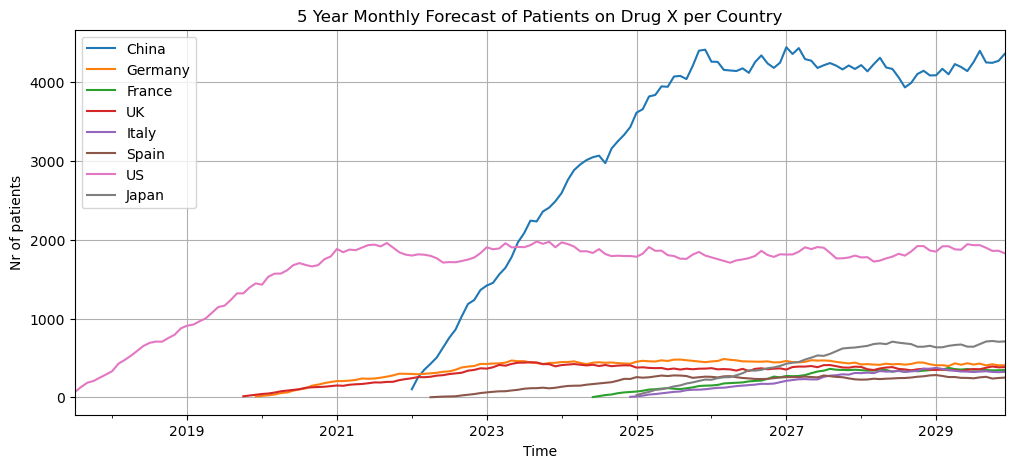

In [6]:
multi_country_forecasts.plot(figsize=(12, 5),
             title=f"{months_to_forecast // 12} Year Monthly Forecast of Patients on Drug X per Country",
             ylabel='Nr of patients',
             xlabel='Time',
             grid=True)

### 🧭 Shaping Worst / Base / Best Case Scenarios
To evolve this analysis into useful strategic scenarios, instead of 1 simulation per country, I can run many simulations (like in the previous chapter 02).

✅ Add Simulation Loops Per Country

In [7]:
results = {country: [] for country in assumptions['Country']}

for _ in range(num_simulations):
    for k in range(country_nr):
        # simulate as before
        for k in range(country_nr):
            df = simulate_monthly_eligibles(
                annual_eligibles=assumptions_df['Annual_Eligible_Pts'][k],
                n_months=assumptions_df['months_to_forecast'][k],
                start_date=assumptions_df['Launch_Date'][k]
            ) # to be passed to eligible_df argument in the next function
            df = simulate_pts_seen_by_users(
                eligible_df=df,
                max_user_share=assumptions_df['max_user_share'][k],
                initial_user_share=assumptions_df['initial_user_share'][k],
                months_to_peak=assumptions_df['months_to_peak'][k]
            ) # to be passed to user_seen_df argument in the next function
            df = simulate_new_pts_treated(
                user_seen_df=df,
                mean_treatment_prob=assumptions_df['Probability_to_prescribe'][k]
            ) # to be passed to df argument in the next function
            df = simulate_forecast(
                df=df,
                median_duration_months=median_duration,
                max_duration_months=max_duration
            )
            results[assumptions['Country'][k]].append(df)


**Notice** that this approach—looping over each country within every simulation—is computationally intensive. 
Running just 10 simulations takes quite a few seconds. Therefore a more efficient implementation is needed.

### 📊 Summary of Multi-Market Forecast Simulations
In this section, I have executed 10 forecast simulations per country for Drug X. Each simulation models patient uptake dynamics based on local market assumptions—such as eligible population size, launch timing, user adoption, prescribing probability, and treatment persistence.

Although informative, this approach—looping over each country within every simulation—is computationally intensive. Even a modest number of simulations introduces noticeable runtime delays.

To scale up to hundreds or thousands of simulations per country (e.g., to build robust uncertainty ranges or scenario-based forecasts), a more efficient implementation is needed.

### 🚀 Next Step: Vectorizing the Simulation Pipeline
In the next section, I will refactor and vectorize the simulation functions to enable faster execution while preserving the realism and stochasticity of the forecast model.